In [9]:
import numpy as np
import keras
import cv2
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [10]:
file_path = 'D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\celeba\img'
labels_path = 'D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\celeba\labels.csv'

In [11]:
df = pd.read_csv(labels_path)

df["smiling"] = df["smiling"].replace(to_replace=[-1], value=['Frown'])
df["smiling"] = df["smiling"].replace(to_replace=[1], value=['Smile'])
df["gender"] = df["gender"].replace(to_replace=[-1], value=['Female'])
df["gender"] = df["gender"].replace(to_replace=[1], value=['Male'])

one_hot_s = pd.get_dummies(df["smiling"])
one_hot_g = pd.get_dummies(df["gender"])
df = df.drop(columns=["gender", "smiling"])
df = df.join(one_hot_g)
df = df.join(one_hot_s)

In [12]:
train, validation, test = \
              np.split(df.sample(frac=1), 
                       [int(.6*len(df)), int(.8*len(df))])

In [13]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(dataframe=train, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Female", "Male"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=30, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

validation_generator = datagen.flow_from_dataframe(dataframe=validation, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Female", "Male"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=10, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

test_generator = datagen.flow_from_dataframe(dataframe=test, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Female", "Male"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=10, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

Found 3000 validated image filenames.
Found 1000 validated image filenames.
Found 1000 validated image filenames.


In [14]:
model = Sequential()
model.add(InputLayer(input_shape=(55,45,1)))
model.add(Conv2D(filters=96, kernel_size=(4,4), strides=4, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=1, activation="relu", padding="same"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2,2), activation="relu", strides=1, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 12, 96)        1632      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 6, 96)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 6, 96)          384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 6, 256)         221440    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 256)        

In [22]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [24]:
history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_steps,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    epochs=15)

Epoch 1/15
100/100 [==============================] - 38s 384ms/step - loss: 0.0249 - accuracy: 0.9900 - val_loss: 0.0512 - val_accuracy: 0.8530
Epoch 2/15
100/100 [==============================] - 8s 76ms/step - loss: 0.0326 - accuracy: 0.9887 - val_loss: 0.1598 - val_accuracy: 0.8710
Epoch 3/15
100/100 [==============================] - 8s 77ms/step - loss: 0.0178 - accuracy: 0.9937 - val_loss: 1.1572 - val_accuracy: 0.8280
Epoch 4/15
100/100 [==============================] - 8s 78ms/step - loss: 0.0321 - accuracy: 0.9880 - val_loss: 1.5380 - val_accuracy: 0.8480
Epoch 5/15
100/100 [==============================] - 8s 79ms/step - loss: 0.0242 - accuracy: 0.9923 - val_loss: 0.4288 - val_accuracy: 0.8360
Epoch 6/15
100/100 [==============================] - 8s 77ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.0653 - val_accuracy: 0.8500
Epoch 7/15
100/100 [==============================] - 8s 75ms/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 8.9116e-04 - val_accuracy: 

In [25]:
model.evaluate(test_generator)

100/100 [==============================] - 16s 164ms/step


[0.02754760906100273, 0.8709999918937683]

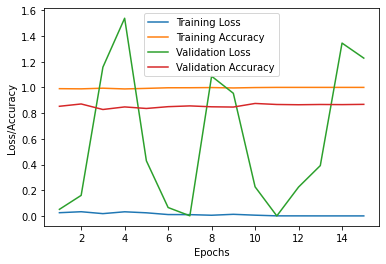

In [26]:
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()